# CH3

## Loading Libraries

In [ ]:
import os
# Change to the directory of the current file to match location in computer 

os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\Markowitz Optimization Final Code\CH3")
import sys 
sys.path.append(r"D:\MyDrive\10. MS in Data Science UofWisconsin\Markowitz Optimization Final Code\CH3")
import numpy as np 
import pandas as pd 
from LopezRandomMethod import random_gen_weights
from unitCircle import unitCircle as unitCircleDf
import matplotlib.pyplot as plt
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone



The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\Markowitz Optimization Final Code\CH3


## Presentation of Unit Circle

Creating Random Weights Df and Dataframe of Daily Returns

In [51]:
np.random.seed(1986)
from randomness_by_RogerStafford import randfixedsum 

n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)
    unif_rand_n=np.random.uniform(low=1,high=100,size=n_cols)
    row_unif = unif_rand_n/unif_rand_n.sum()
    data.append(row)
    data_uniform.append(row_unif)

df_weights = pd.DataFrame(data)
df_weights_unif = pd.DataFrame(data_uniform)

rand_RS,v = randfixedsum(30, 10000, 1, 0, 1)
df_weights_RS = pd.DataFrame(rand_RS.T)




#downloading only last year as I believe is more representative of the picture going forward
df_weights = pd.DataFrame(data)
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


#%%
## 41 rows of daily pct change in aug and sept 2024.
## Limiting to evaluation period that ends in Jul 2024
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()

training_pct_change=training_1y_endJul2024.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


Weights of DJI last Trading Day of Jul 2024, and equal weighted portfolio

In [27]:
from siuba import *
weights_DJI=training_1y_endJul2024 >> filter(_.index == _.index.max()) >> _.apply(lambda x: x/sum(x), axis=1) >> _.iloc[0,:]
eqWeight=np.repeat(1/3,30)

# GETTING COORDINATES
y_recentDJI=np.array(weights_DJI).dot(unitCircleDf['heights'])
x_recentDJI=np.array(weights_DJI).dot(unitCircleDf['lengths'])
y_eqWeight=np.array(eqWeight).dot(unitCircleDf['heights'])
x_eqWeight=np.array(eqWeight).dot(unitCircleDf['lengths'])

# CREATING PORTFOLIO DATAFRAME 
df_unitCircle_Portfolios=pd.DataFrame({'x':[x_eqWeight,x_recentDJI],'y':[y_eqWeight,y_recentDJI],'Portfolios': ['Eq. Weight','DJI']})

Graphing

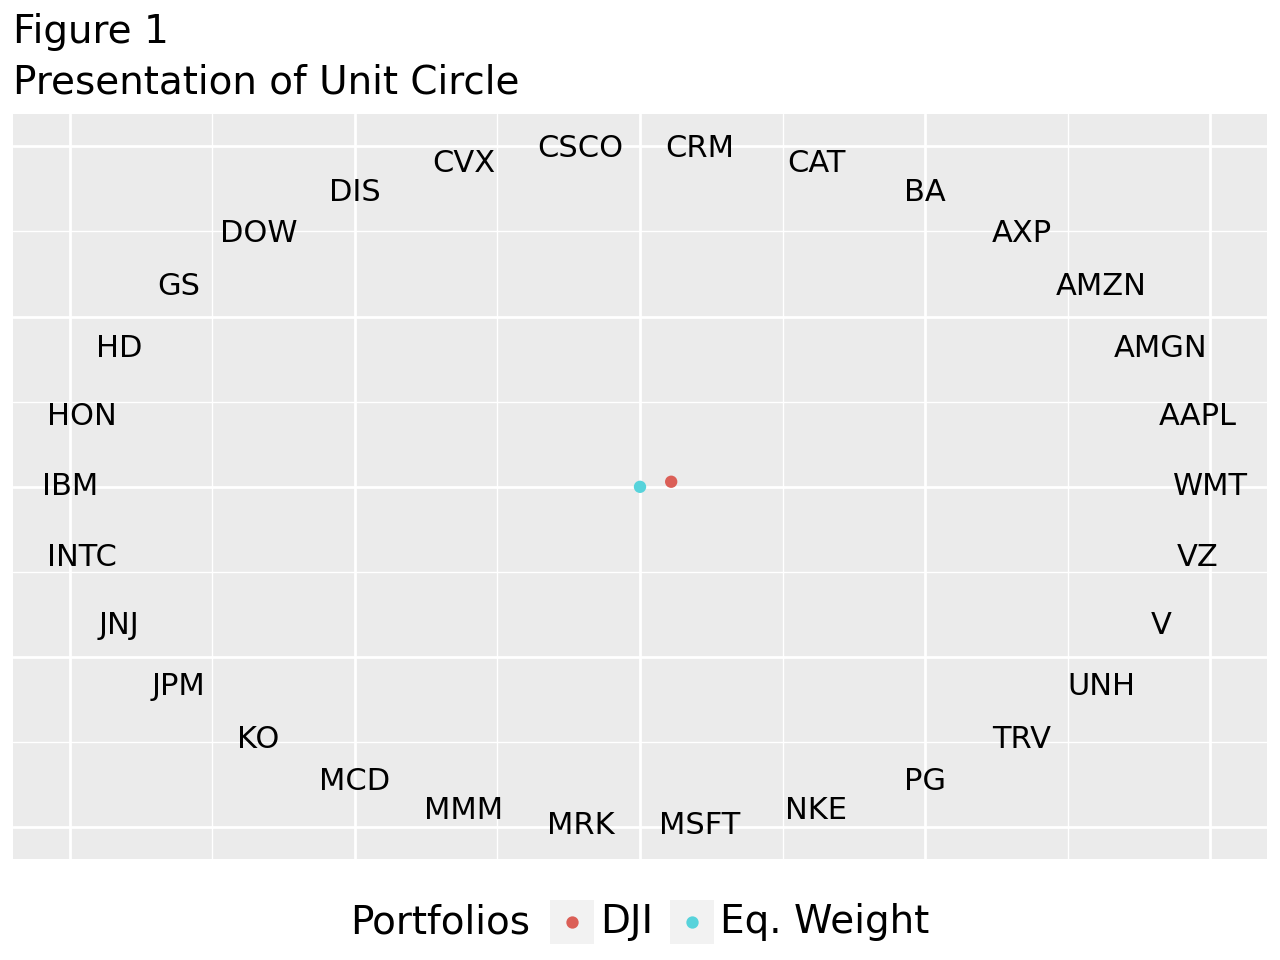

In [28]:
from plotnine import *
unitCircleDf >> ggplot()+ geom_text(aes(x='lengths',y='heights',label='securities')) +\
geom_point(df_unitCircle_Portfolios,aes(x='x', y='y', color='Portfolios')) + \
    theme(text=element_text(family='sans-serif',size=14) ,legend_position= 'bottom', 
          axis_text=element_blank(), axis_ticks=element_blank())+ labs(x='', y ='') + labs(title='Figure 1', subtitle='Presentation of Unit Circle')

## Weight Difference from DJI to Equally Weighted Portfolio

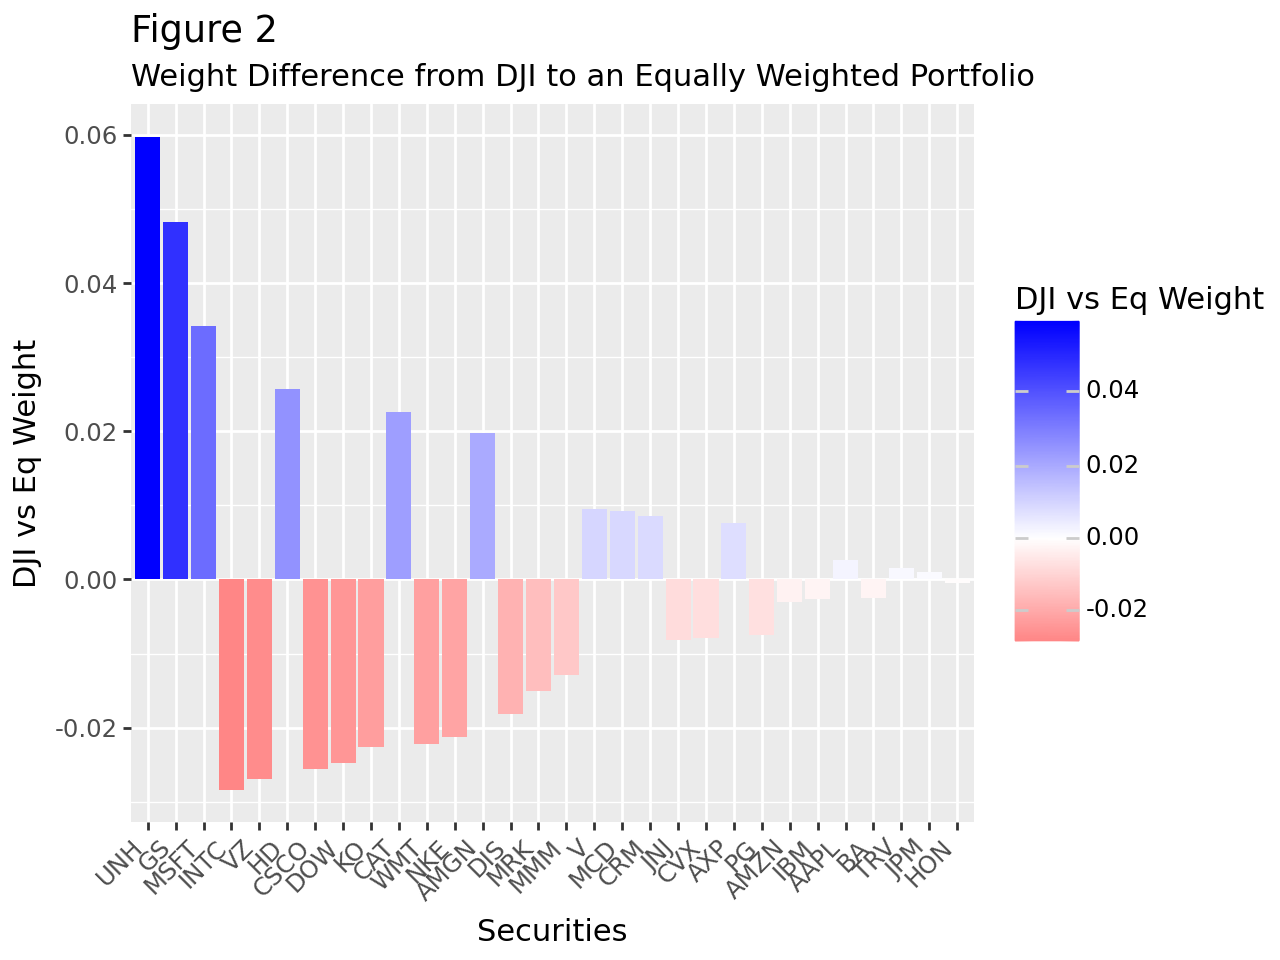

In [32]:
pd.DataFrame({'DJI vs Eq Weight':weights_DJI - (1/30)}) >> \
    mutate(abs_diff = abs(_['DJI vs Eq Weight']), inv_diff = -_['DJI vs Eq Weight']) >> \
arrange(-_.abs_diff) >> _.reset_index() >> \
    ggplot() + geom_col(aes(x='reorder(index, -abs_diff)',y='DJI vs Eq Weight', fill='DJI vs Eq Weight'))+\
    scale_fill_gradient2(low='red', mid='white', high='blue', midpoint=0)+theme(axis_text_x=element_text(rotation=45, hjust=1))+\
    labs(x='Securities', title='Figure 2', subtitle='Weight Difference from DJI to an Equally Weighted Portfolio')

## Weight Composition of the 10 Largest Securities

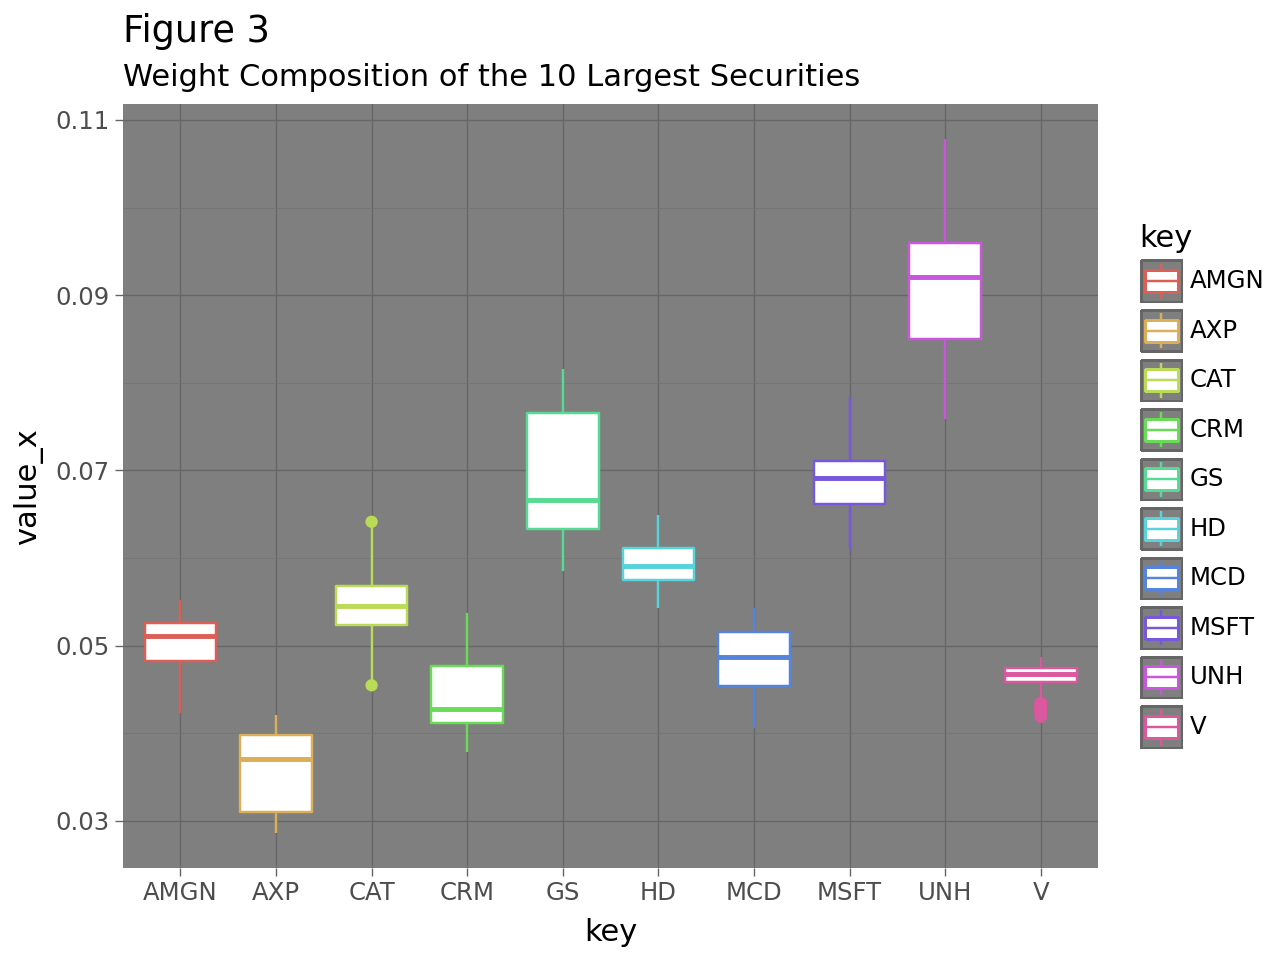

In [34]:
# top 10 companies by weight as of sept 27, 2024
df_top10_byWeight=df_ticker_price1.apply(lambda x: x/sum(x), axis=1) >> filter(_.index == '2024-09-27') >> gather() >> \
arrange(-_.value) >> head(10)

#%%
# box plot of weights in time of biggest 10 securities (price) 

bx_big10Sec=df_ticker_price1.apply(lambda x: x/sum(x), axis=1) >>\
     gather(key='key', value='value') >> \
     inner_join(_,df_top10_byWeight, by = {'key':'key'})>> ggplot() + geom_boxplot(aes(x='key',y='value_x', color='key')) + \
     theme(text=element_text(family='sans-serif',size=14),
      plot_title=element_text(hjust=0, family='sans-serif', size=14),
        plot_subtitle=element_text(hjust=0, family='sans-serif', size=14, style='italic',margin={'t': 20})
    ) +theme_dark()

#gt1._options.container_padding_y 
bx_big10Sec + labs(title='Figure 3', subtitle='Weight Composition of the 10 Largest Securities')

## Distribution of Weights Naive Approach

Please note that due to randomness results might look slightly different from what is shown in the paper

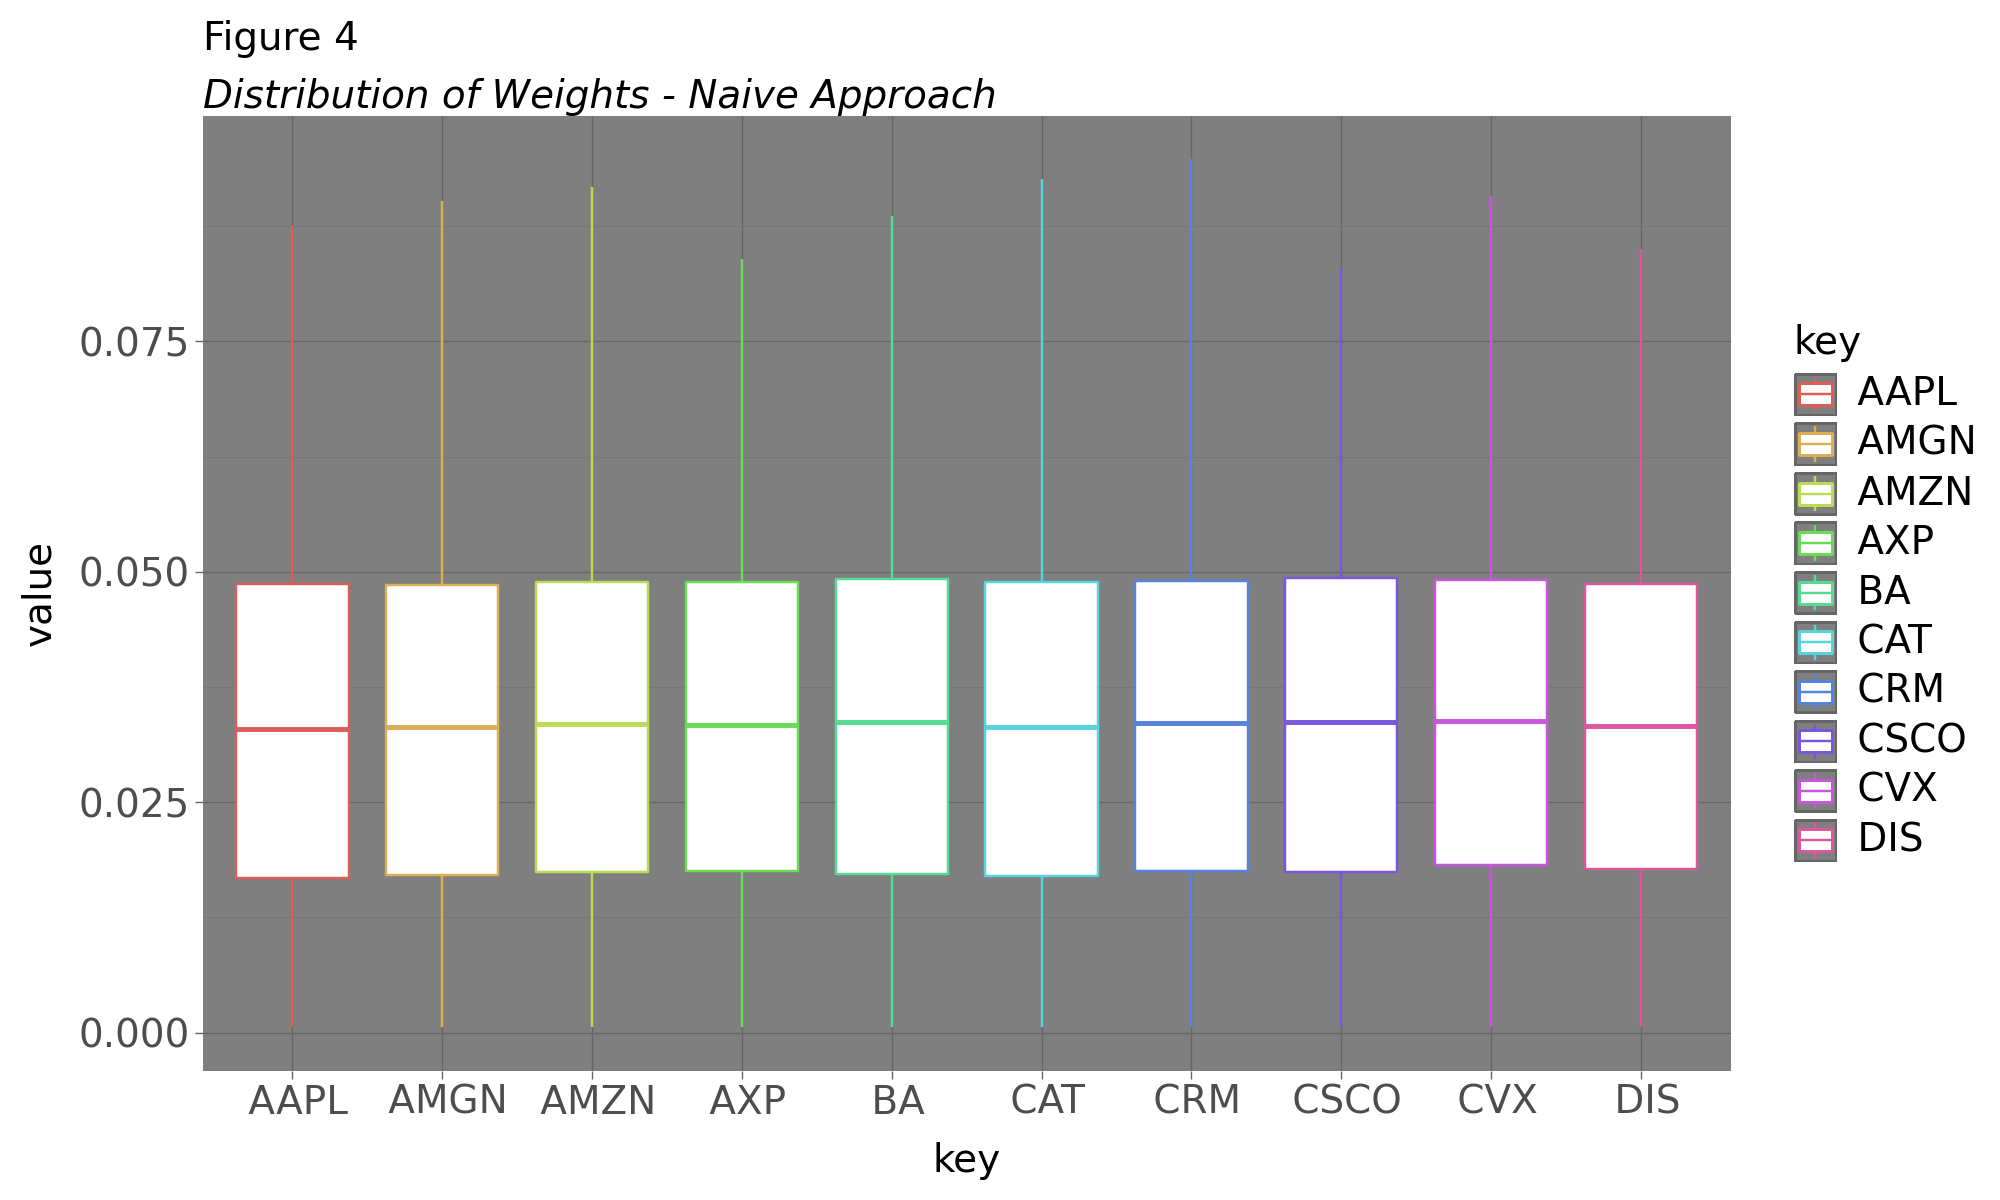

In [59]:
from siuba import *
df_weights_unif = pd.DataFrame(data_uniform)
df_names=pd.read_excel('marketInsider.xlsx',sheet_name='automatically')
df_weights_unif.columns = df_names['ticker']
distro_uniform= df_weights_unif>> select(_[:10]) >> \
gather('key','value') >> ggplot() + geom_boxplot(aes(x='key',y='value', color='key'))+\
theme_dark() + \
theme(text=element_text(family='sans-serif',size=14),
      plot_title=element_text(hjust=0, family='sans-serif', size=14),
        plot_subtitle=element_text(hjust=0, family='sans-serif', size=14, style='italic',margin={'t': 20})
    )

distro_uniform + labs(title='Figure 4', subtitle='Distribution of Weights - Naive Approach') + theme(figure_size=(10,6))


<u>Observation of max values of each column from Naive Approach Randomization</u> <br>
- Notice that no max is greater than **0.1** - proving that this is not really random

In [73]:
df_weights_unif >> gather('key','value') >> \
group_by(_.key) >> summarize(mean_value = _.value.mean(), 
                             median_value = _.value.median(), 
                             max_value = _.value.max(),
                             min_value = _.value.min()
                             
                             ) >> ungroup() >> _.describe()

mean_value  median_value  max_value  min_value
count   30.000000     30.000000  30.000000  30.000000
mean     0.033333      0.033393   0.089007   0.000611
std      0.000193      0.000310   0.003261   0.000031
min      0.033003      0.032784   0.082969   0.000556
25%      0.033182      0.033141   0.086675   0.000588
50%      0.033365      0.033449   0.088829   0.000606
75%      0.033480      0.033650   0.090776   0.000633
max      0.033681      0.033838   0.096116   0.000697

## Roger Stafford Distribution

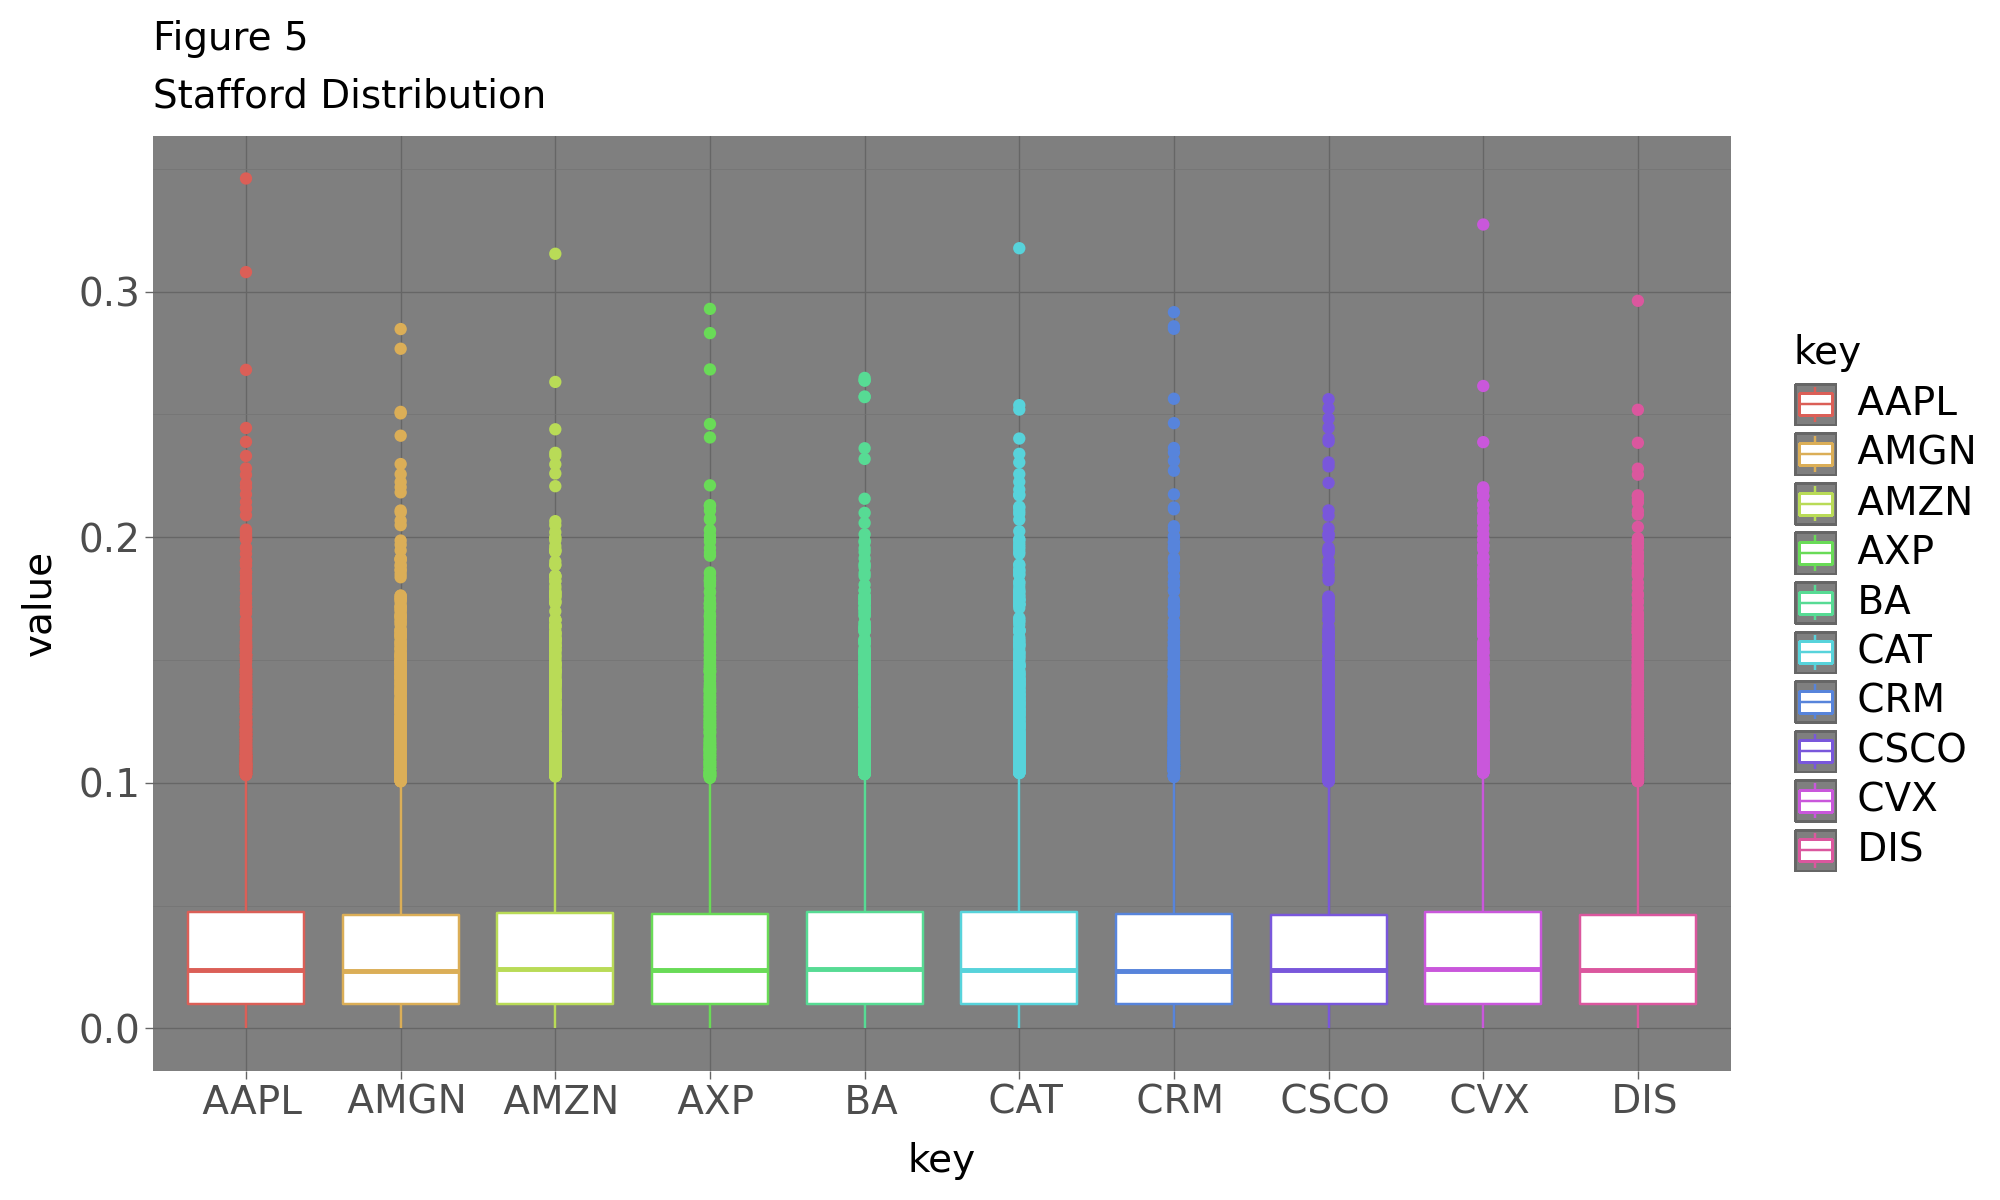

In [58]:
df_weights_RS.columns = df_names['ticker']

RogerStaffordDistro=df_weights_RS>> select(_[:10]) >> \
gather('key','value') >> ggplot() + geom_boxplot(aes(x='key',y='value', color='key'))+\
theme_dark() + \
theme(text=element_text(family='sans-serif',size=14)      
    )

RogerStaffordDistro + labs(title='Figure 5', subtitle='Stafford Distribution') + theme(figure_size=(10,6))

<u>Observations on Min, Mean and Max for Stafford</u> <br>
- Maxima oscilates between .25 and .35
- Mean oscilates around 0.03 (as expected)
- Minima is zero


In [72]:
df_weights_RS >> gather('key','value') >> \
group_by(_.key) >> summarize(mean_value = _.value.mean(), 
                             median_value = _.value.median(), 
                             max_value = _.value.max(),
                             min_value = _.value.min()
                             
                             ) >> ungroup() >> _.describe()

mean_value  median_value  max_value     min_value
count   30.000000     30.000000  30.000000  3.000000e+01
mean     0.033333      0.023677   0.284936  2.856390e-06
std      0.000345      0.000362   0.028216  3.147116e-06
min      0.032689      0.023177   0.245368  1.196080e-07
25%      0.033098      0.023420   0.263263  9.182791e-07
50%      0.033242      0.023626   0.278396  1.417691e-06
75%      0.033576      0.023820   0.301542  4.030751e-06
max      0.034079      0.024686   0.350162  1.414325e-05

## López Distribution

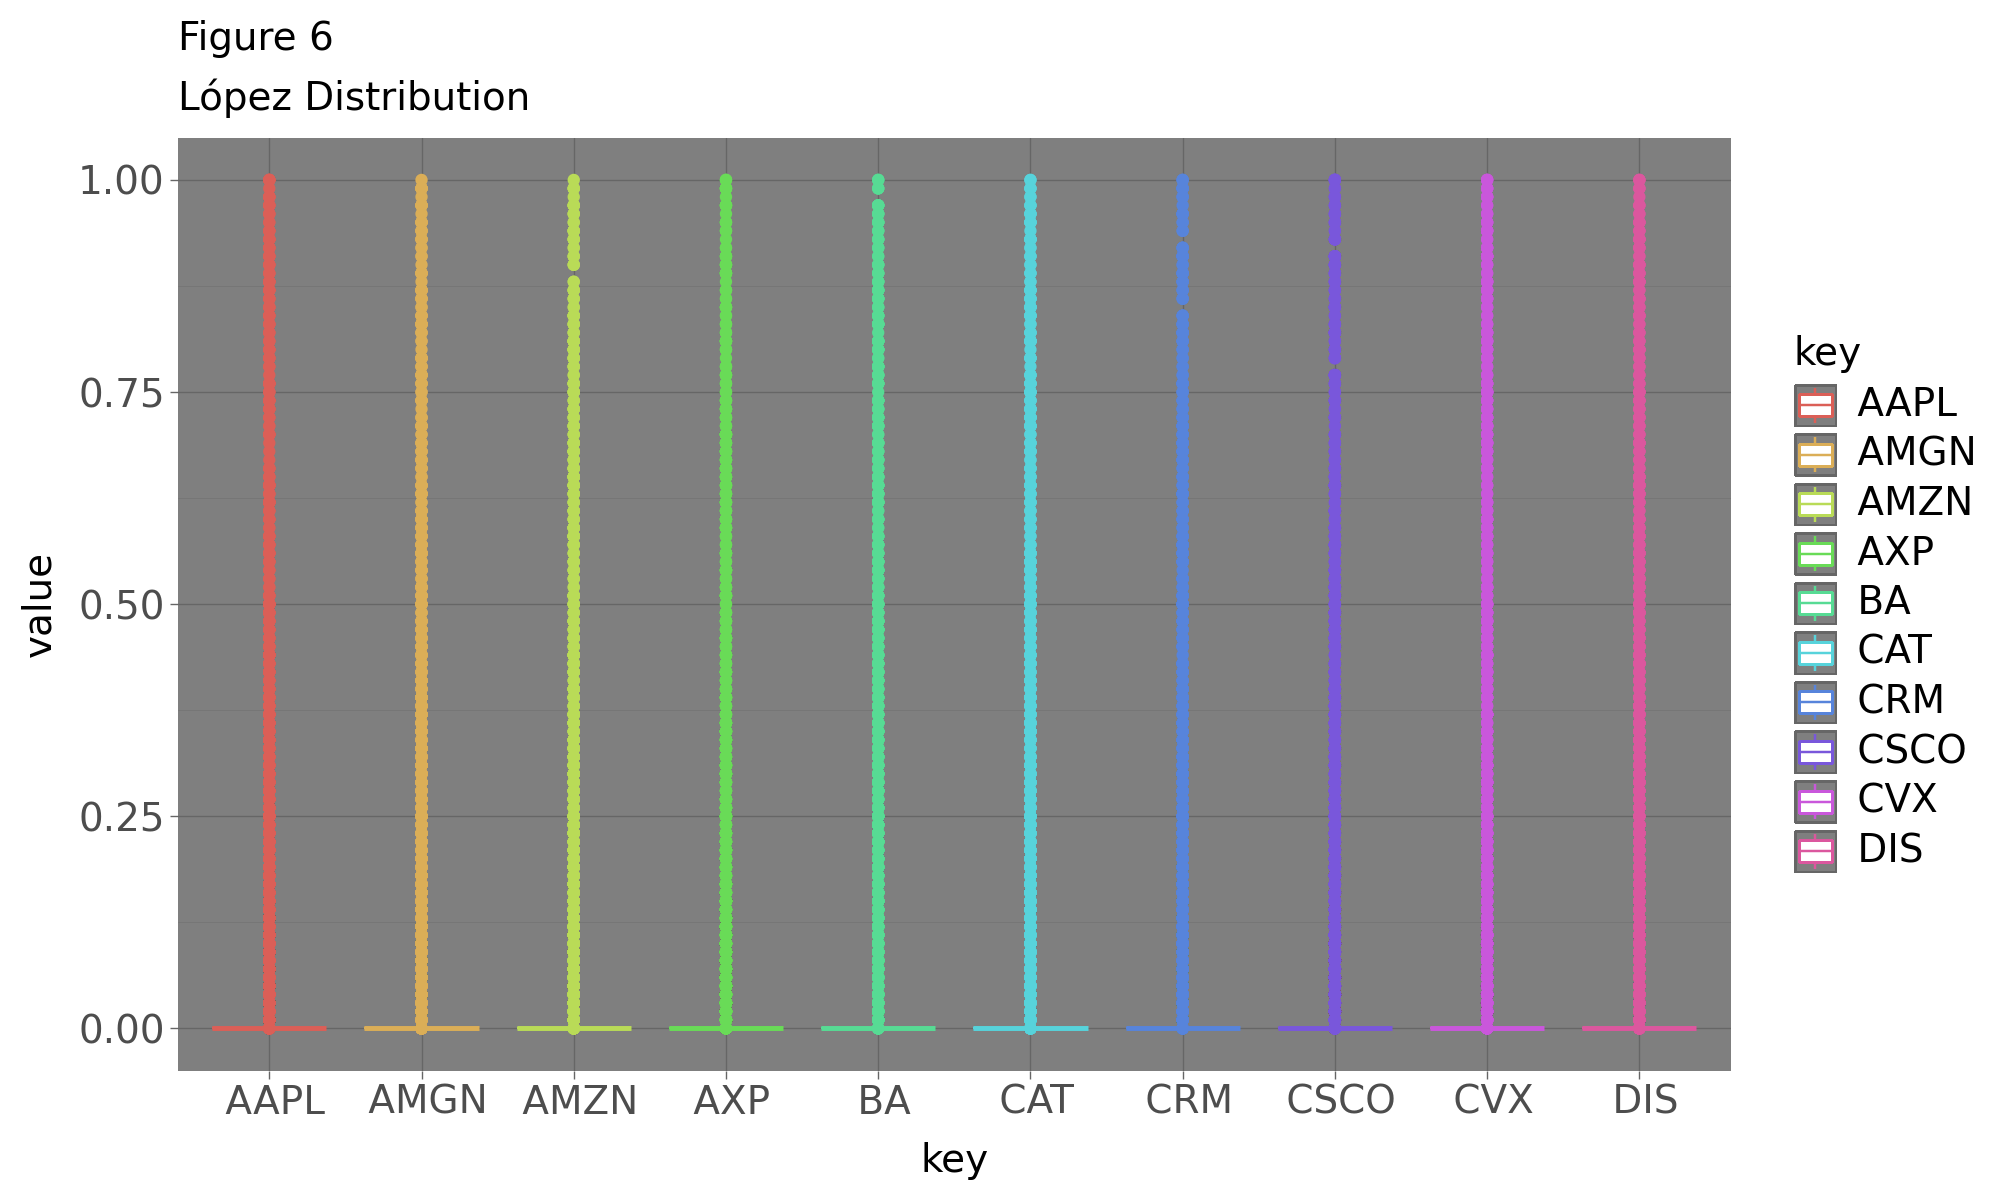

In [65]:
df_weights.columns = df_names['ticker']

LopezDistro = df_weights>> select(_[:10]) >> \
gather('key','value') >> ggplot() + geom_boxplot(aes(x='key',y='value', color='key'))+\
theme_dark() + \
theme(text=element_text(family='sans-serif',size=14)      
    )

LopezDistro+ labs(title='Figure 6', subtitle='López Distribution') + theme(figure_size=(10,6))

In [ ]:

df_weights >> gather('key','value') >> \
group_by(_.key) >> summarize(mean_value = _.value.mean(), 
                             median_value = _.value.median(), 
                             max_value = _.value.max(),
                             min_value = _.value.min()
                             
                             ) >> ungroup() >> _.describe()

mean_value  median_value  max_value  min_value
count   30.000000          30.0  30.000000       30.0
mean     0.033333           0.0   0.999333        0.0
std      0.001250           0.0   0.002537        0.0
min      0.030606           0.0   0.990000        0.0
25%      0.032623           0.0   1.000000        0.0
50%      0.033293           0.0   1.000000        0.0
75%      0.034266           0.0   1.000000        0.0
max      0.035471           0.0   1.000000        0.0

## All Random Methods Graphically

In [74]:

h_Lopez=[row.dot(unitCircleDf['heights']) for row in df_weights.values]
w_Lopez=[row.dot(unitCircleDf['lengths']) for row in df_weights.values]

h_unif=[row.dot(unitCircleDf['heights']) for row in df_weights_unif.values]
w_unif=[row.dot(unitCircleDf['lengths']) for row in df_weights_unif.values]

h_Stafford=[row.dot(unitCircleDf['heights']) for row in df_weights_RS.values]
w_Stafford=[row.dot(unitCircleDf['lengths']) for row in df_weights_RS.values]

Lopez_rnd=pd.DataFrame({
    'height': h_Lopez,
    'width': w_Lopez,
    'method': 'Lopez'
})

Unif_rnd = pd.DataFrame({
    'height': h_unif,
    'width': w_unif,
    'method': 'Uniform'
})

Stafford_rnd = pd.DataFrame({
    'height': h_Stafford,
    'width': w_Stafford,
    'method': 'Stafford'
})

all_methods_random = pd.concat([Lopez_rnd,Stafford_rnd, Unif_rnd ])

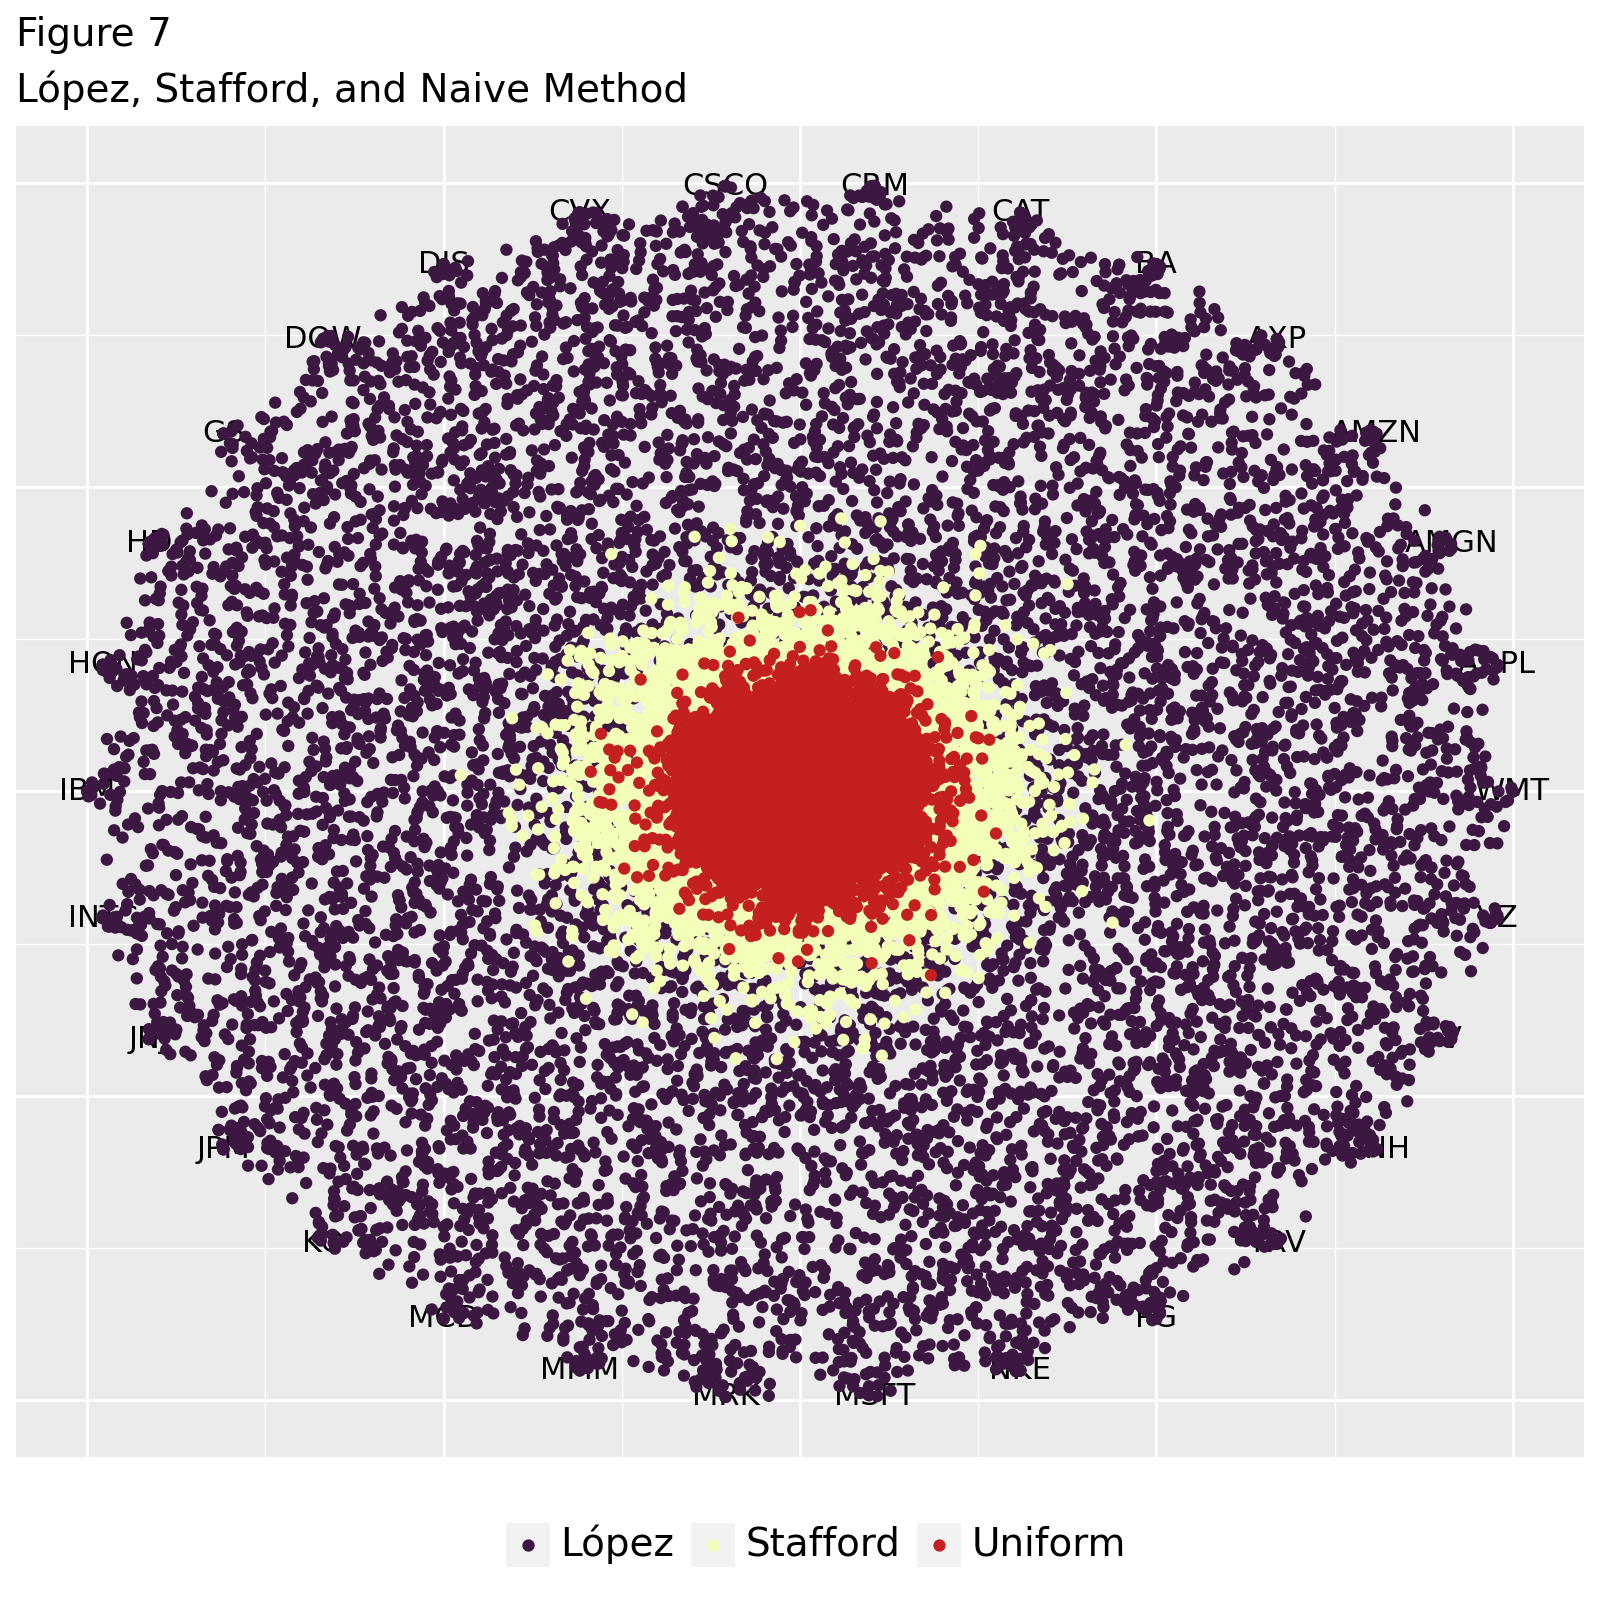

In [78]:

random_method_unitCircle=unitCircleDf >> ggplot()+ \
geom_text(aes(x='lengths',y='heights',label='securities'))+\
geom_point(all_methods_random,aes(x='width', y='height', color='method'),  show_legend=True) +\
scale_color_manual(
    name='\n',
    values={'Lopez': '#3C1742', 'Stafford': '#F3FFB9', 'Uniform': '#C42021'},
    labels={'Lopez': 'López', 'Stafford': 'Stafford', 'Uniform': 'Uniform'}
) + \
labs(x='',y='')+ \
    theme(text=element_text(family='sans-serif',size=14), 
          legend_position= 'bottom',
          axis_line=element_blank(),
          axis_text=element_blank(),
          axis_ticks=element_blank()
        ) 

random_method_unitCircle+ labs(title='Figure 7', subtitle='López, Stafford, and Naive Method') + theme(figure_size=(8,8))

## Optimization Section

Sharpe of DJI (based on weights from last trading day of July)

In [79]:
mean_DJI = training_pct_change.dot(weights_DJI).mean()*41
sd_DJI = training_pct_change.dot(weights_DJI).std()*np.sqrt(41)

print(f"Sharpe DJI = {mean_DJI/sd_DJI}")

Sharpe DJI = 0.7790447335034036


Calculating Sharpe Ratio for Every Single Random Portfolio that was generated using Lopez Method

In [80]:
port_means= []
port_sd = []
for row in df_weights.values: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
    port_sd.append(i_sd * np.sqrt(41))
    
#%%
#renaming columns and adding sharpe ratio
df_weights.columns = training_pct_change.columns
df_weights['port_return'] = port_means
df_weights['port_risk'] = port_sd
df_weights['sharpe'] = df_weights['port_return']/df_weights['port_risk']

Best Sharpe from Lopez Method (notice this might be slightly different from what is in the paper due to randomness)

In [90]:
print(f"Sharpe Best Portfolio from Lopez Method = {df_weights.sharpe.max():.4f}")
print(f"Sharpe Best Portfolio from Lopez Method over Sharpe DJI Last Trading Day = {df_weights.sharpe.max()/(mean_DJI/sd_DJI) -1 : .2f}")

Sharpe Best Portfolio from Lopez Method = 1.1070
Sharpe Best Portfolio from Lopez Method over Sharpe DJI Last Trading Day =  0.42


### Risk Vs Return 
DJI vs Best Portfolio Prior to Optimization

In [92]:
mean_DJI = training_pct_change.dot(weights_DJI).mean()*41
sd_DJI = training_pct_change.dot(weights_DJI).std()*np.sqrt(41)
df_small_DJI=pd.DataFrame({'x': [sd_DJI], 'y': [mean_DJI]} )

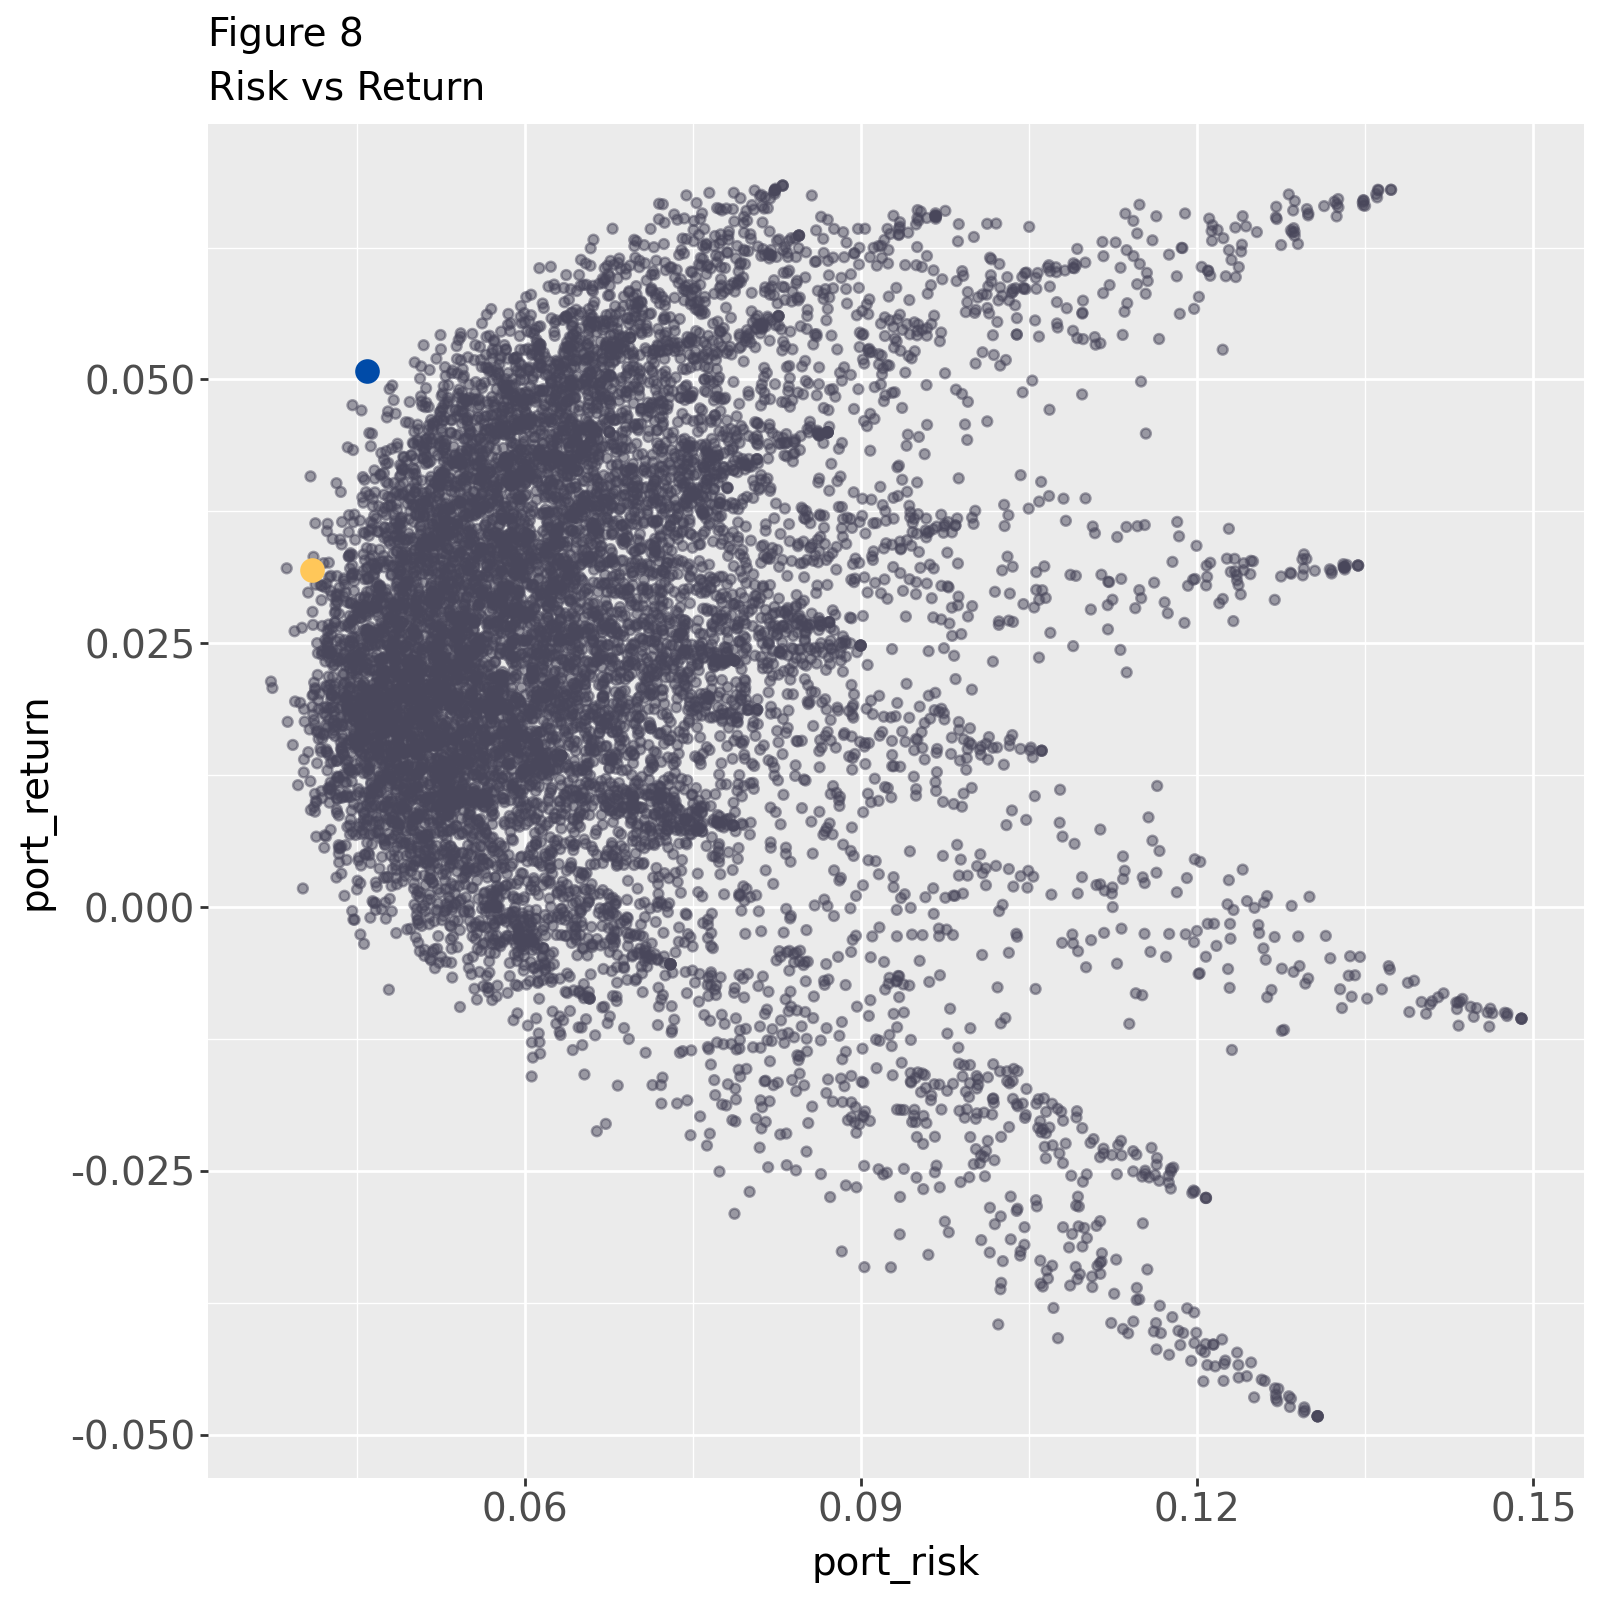

In [95]:
df_weights >> ggplot() + geom_point(aes(x='port_risk', y = 'port_return'), alpha=0.5, color = '#49475B' ) + \
geom_point(df_small_DJI,aes(x='x',y='y'), color='#FFC759', size=4 ) + \
    geom_point(df_weights >> arrange(-_.sharpe) >> head(1), aes(x='port_risk', y = 'port_return'), size=4, color = '#004BA8')+\
    theme(text=element_text(family='sans-serif',size=14)  ,figure_size=(8,8)
    ) + labs(title='Figure 8', subtitle='Risk vs Return')


### Return vs Risk after SLSQP Optim

Setting up formulas for SLSQP Optim

In [97]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]

Optimizing using SLSQP

In [101]:
#initial_guess = [1. / returns.shape[1]] * returns.shape[1]
initial_guess = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()
from scipy.optimize import minimize
result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)

#print("Optimized Weights:", result.x)
print(f"Maximized Sharpe Ratio:, {-result.fun:.4f}")

Maximized Sharpe Ratio:, 1.2882


In [105]:
mean_SLSQP = training_pct_change.dot(result.x).mean()*41
sd_SLSQP = training_pct_change.dot(result.x).std()*np.sqrt(41)
df_small_SLSQP=pd.DataFrame({'x': [sd_SLSQP], 'y': [mean_SLSQP], 'port':['SLSQP']} )

In [106]:
beforeOptim=df_weights >> arrange(-_.sharpe) >> head(1) >> select(_.port_risk, _.port_return) >> rename(x = _.port_risk, y= _.port_return) >> mutate(port = 'beforeOptim')

In [107]:
df_small_DJI['port'] = ['DJI']

port_groups_df=pd.concat([df_small_DJI, df_small_SLSQP,beforeOptim])

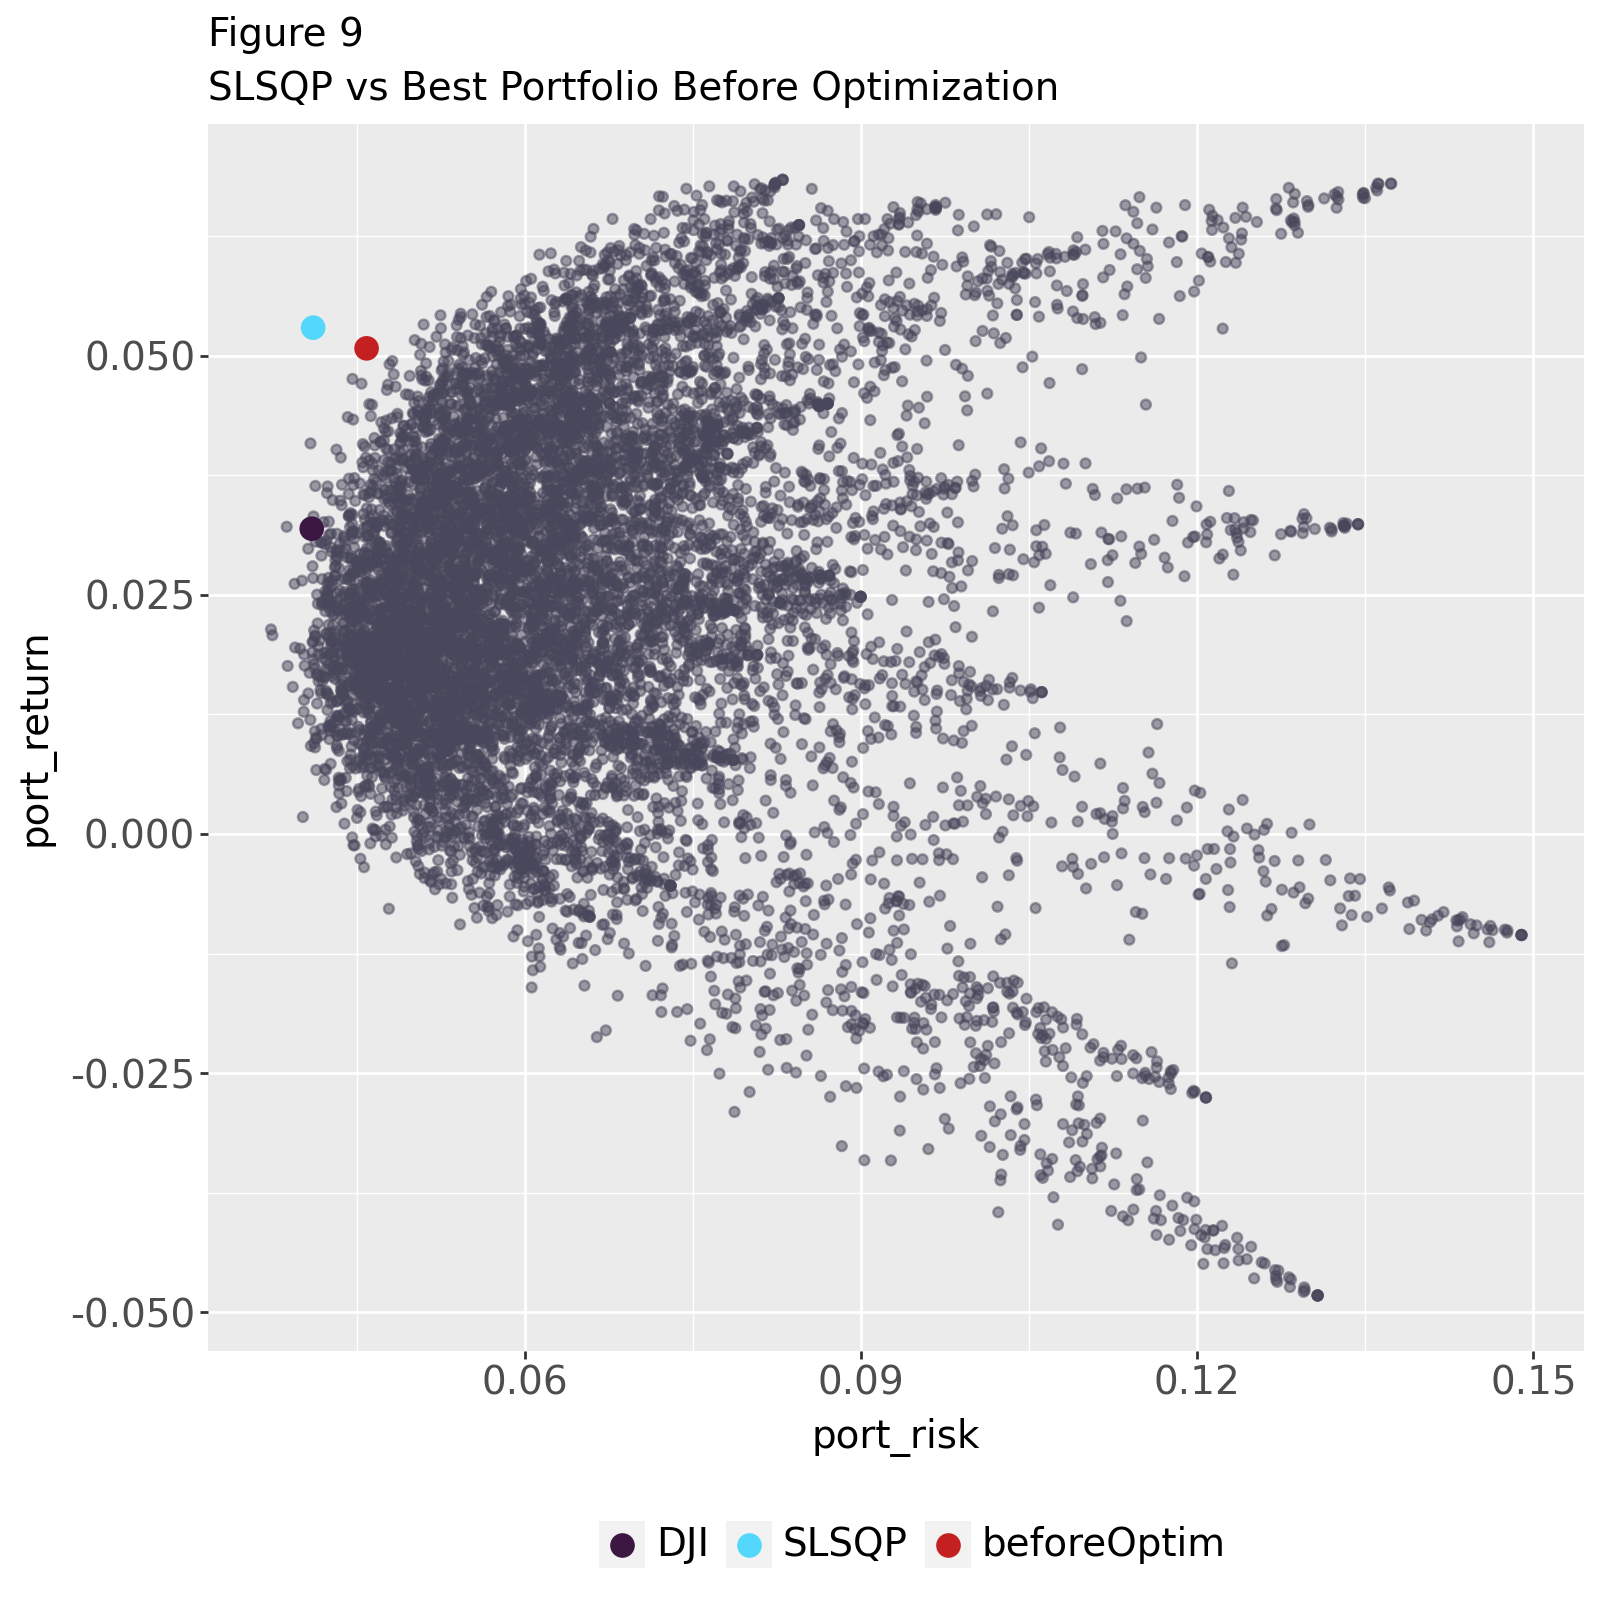

In [110]:
df_weights >> ggplot() + geom_point(aes(x='port_risk', y = 'port_return'), alpha=0.5, color = '#49475B' ) + \
geom_point(port_groups_df,aes(x='x',y='y', color='port'), size=4 ) + scale_color_manual(
    name='\n',
    values={'DJI': '#3C1742', 'SLSQP': '#53D8FB', 'beforeOptim': '#C42021'},
    labels={'Lopez': 'Lopez', 'Stafford': 'Stafford', 'Uniform': 'Uniform'}
)    + \
    theme(text=element_text(family='sans-serif',size=14) ,legend_position= 'bottom',figure_size=(8,8)) + labs(title='Figure 9', subtitle='SLSQP vs Best Portfolio Before Optimization')

#### Unit Circle with SLSQP Optimization

In [111]:

# recent weights DJI 
weights_DJI_recent=(df_ticker_price1.apply(lambda x: x/sum(x), axis=1) >> filter(_.index == '2024-09-27')).iloc[0,:]

#%%

y_recentDJI=np.array(weights_DJI_recent).dot(unitCircleDf['heights'])
x_recentDJI=np.array(weights_DJI_recent).dot(unitCircleDf['lengths'])

In [113]:
beforeOptimWeights=df_weights >> arrange(-_.sharpe) >> head(1) >> _.iloc[0,:30]
y_beforeOptim=np.array(beforeOptimWeights).dot(unitCircleDf.heights)
x_beforeOptim=np.array(beforeOptimWeights).dot(unitCircleDf.lengths)

In [114]:
y_SLSQP=np.array(result.x).dot(unitCircleDf.heights)
x_SLSQP=np.array(result.x).dot(unitCircleDf.lengths)

In [115]:
df_unitCircle_Ports1=pd.DataFrame({'x':[0, x_recentDJI,x_beforeOptim,x_SLSQP],'y':[0,y_recentDJI,y_beforeOptim,y_SLSQP],'Portfolios': ['Eq. Weight','DJI','beforeOptim','SLSQP']})

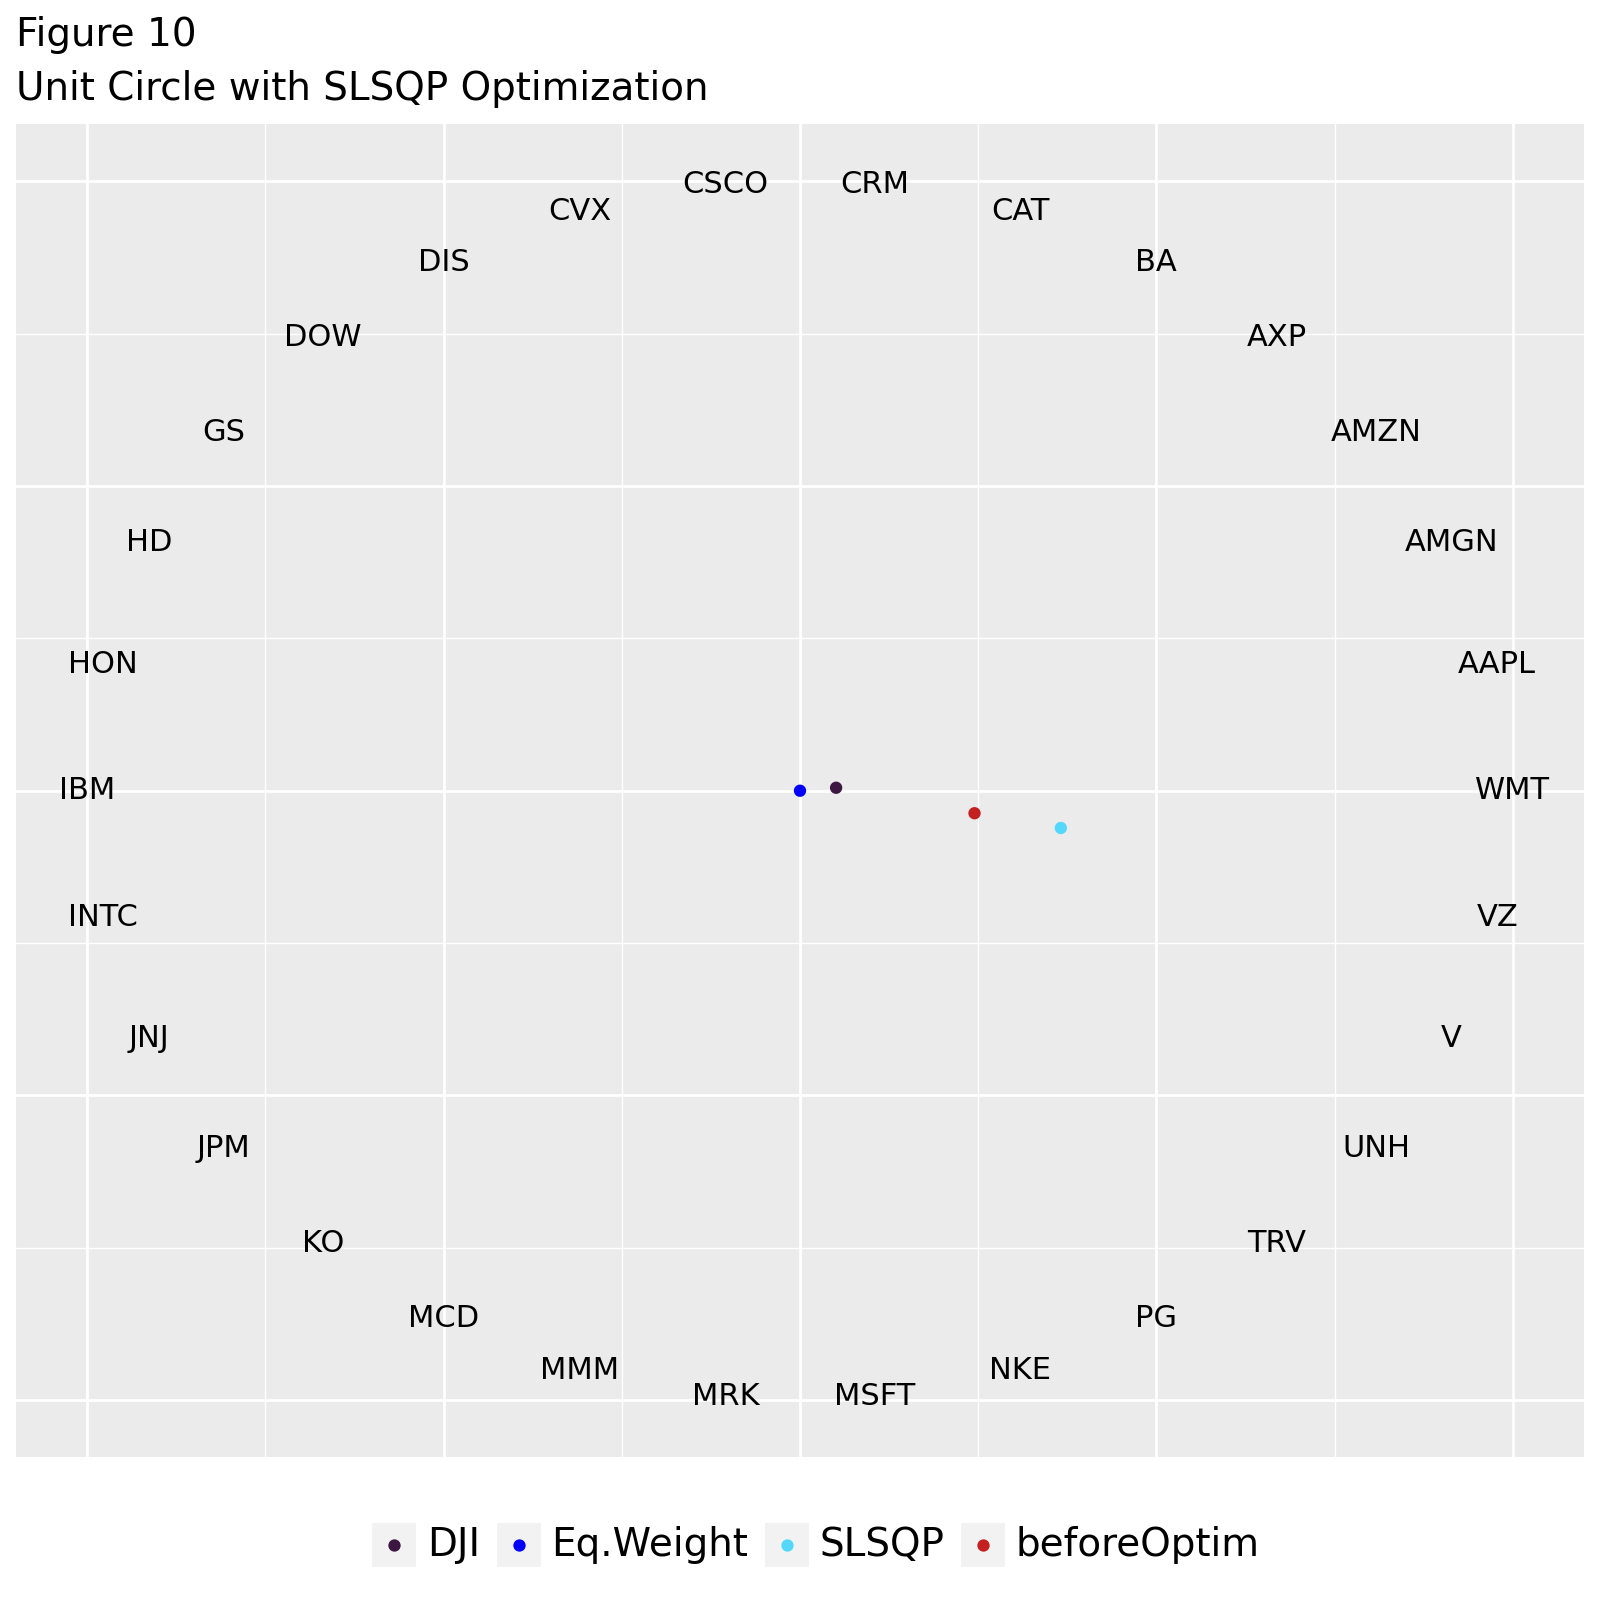

In [ ]:
unitCircleGraph_optim1=unitCircleDf >> ggplot()+ \
geom_text(aes(x='lengths',y='heights',label='securities')) +\
geom_point(df_unitCircle_Ports1,aes(x='x', y='y', color='Portfolios')) + scale_color_manual(
    name='\n',
    values={'DJI': '#3C1742', 'SLSQP': '#53D8FB', 'beforeOptim': '#C42021','Eq. Weight':'blue'},
    labels={'Lopez': 'Lopez', 'Stafford': 'Stafford', 'Uniform': 'Uniform','Eq. Weight':'Eq.Weight'}
)    + \
    theme(text=element_text(family='sans-serif',size=14) ,legend_position= 'bottom', 
          axis_text=element_blank(), axis_ticks=element_blank(),figure_size=(8,8))+ labs(x='', y ='') 

unitCircleGraph_optim1 + labs(title='Figure 10', subtitle='Unit Circle with SLSQP Optimization')

### Simulated Annealing
No optimization of hyperparameters

In [120]:
# weights that produce best Sharpe - Lopez method
beforeOptimWeights=df_weights >> arrange(-_.sharpe) >> head(1) >> _.iloc[0,:30]

In [122]:
import numpy as np
import pandas as pd
from simanneal import Annealer

# Assuming you have your daily returns DataFrame ready
# returns = pd.DataFrame(...)

class PortfolioOptimization(Annealer):
    def __init__(self, state, returns):
        self.returns = returns
        super().__init__(state)

    def move(self):
        """ Randomly adjust a weight """
        i = np.random.randint(0, len(self.state))
        change = np.random.uniform(-0.1, 0.1)
        self.state[i] = min(max(self.state[i] + change, 0), 1)
        self.state = self.state / np.sum(self.state)

    def energy(self):
        return sharpe_ratio(self.state, self.returns)

# Define your initial state (weights)
initial_state = beforeOptimWeights  # Equal weights for simplicity

optimizer = PortfolioOptimization(initial_state, training_pct_change)
optimizer.steps = 10000
best_state, best_energy = optimizer.anneal()

#print("Optimal weights:", best_state)
print("Optimal Sharpe ratio:", -best_energy)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.87    99.00%    46.00%     0:00:06     0:00:00

Optimal Sharpe ratio: 1.106967100670091


#### Optimizing Annealing Hyperparameters

In [123]:
auto_schedule = optimizer.auto(minutes=1) 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000         -1.29    30.00%     0.00%     0:00:53    -1:59:12

In [124]:
auto_schedule

{'tmax': 0.48, 'tmin': 2.6e-08, 'steps': 110000, 'updates': 100}

In [125]:
optimizer.set_schedule(auto_schedule)

In [130]:
%%time
best_state, best_energy = optimizer.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000         -1.29    30.27%     0.00%     0:00:56     0:00:00

CPU times: total: 50.4 s
Wall time: 56 s


In [129]:
print(f"best sharpe from annealing optimization after optimizing hyperparameters: {-best_energy:.4f}")

best sharpe from annealing optimization after optimizing hyperparameters: 1.2882


### Dual Annealing Optimization

Please note that result from Dual Optimization might change due to randomness

In [ ]:
%%time
import numpy as np
import pandas as pd
from scipy.optimize import dual_annealing

# Load or generate your returns data
# Here we create a dummy DataFrame; replace this with your actual returns data

returns = training_pct_change # 41 days of returns for 30 stocks

# Set the bounds for the weights (0 to 1)
bounds = [(0, 1) for _ in range(returns.shape[1])]

# Define a penalty function for weights sum constraint
def penalty(weights):
    return 1000 * abs(np.sum(weights) - 1)

# Cost function with penalty
def cost_function(weights, returns):
    return sharpe_ratio(weights, returns) + penalty(weights)
# Constraint for the sum of weights to be 1
#constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Custom hyperparameters
hyperparameters = {
    'initial_temp': 5230.0,  # Initial temperature
    'restart_temp_ratio': 2e-5,  # Reheating parameter
    'maxiter': 10000  }

# Optimize using dual_annealing
result = dual_annealing(lambda weights: cost_function(weights, returns),
                        bounds=bounds, **hyperparameters)

# Optimal weights
optimal_weights = result.x
print("Optimal Weights: ", optimal_weights)

# Verify the sum of weights
print("Sum of Weights: ", np.sum(optimal_weights))
print(f"Result of function {-result.fun}")
